<h1>Further analysing the data to understand the results of the model</h1>

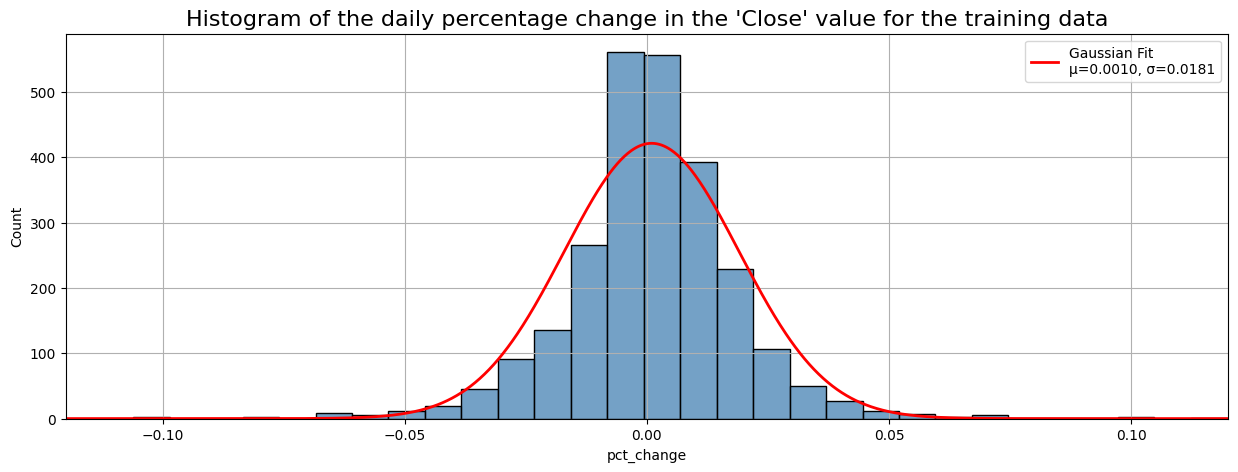

In [130]:
from scipy.stats import norm

train_data['pct_change'] = train_data['Close_AAPL'].pct_change(periods=1)
pct_changes = train_data['pct_change'].dropna()
mu, sigma = norm.fit(pct_changes)
x = np.linspace(-0.12, 0.12, 1000)

# the histogram
plt.figure(figsize=(15, 5))
binwidth = 0.0075
sns.histplot(pct_changes, binwidth=binwidth, kde=False, stat='count', color='steelblue')
hist_count = len(pct_changes)
pdf_scaled = norm.pdf(x, mu, sigma) * hist_count * binwidth

# the fitted Gaussian
plt.plot(x, pdf_scaled, color='red', linewidth=2, label=f'Gaussian Fit\nμ={mu:.4f}, σ={sigma:.4f}')
plt.title("Histogram of the daily percentage change in the 'Close' value for the training data", size=16)
plt.xlabel("pct_change")
plt.ylabel("Count")
plt.xlim(-0.12, 0.12)
plt.legend()
plt.grid(True)
plt.show()

Near-zero mean:	the dataset is consistent with efficient market hypothesis (small edge if any)

Bell curve shape: the stocks tend to approximate this in stable periods

Slight fat tails: something normal due to unexpected market shocks

Positive skew not present:	good

No major anomalies

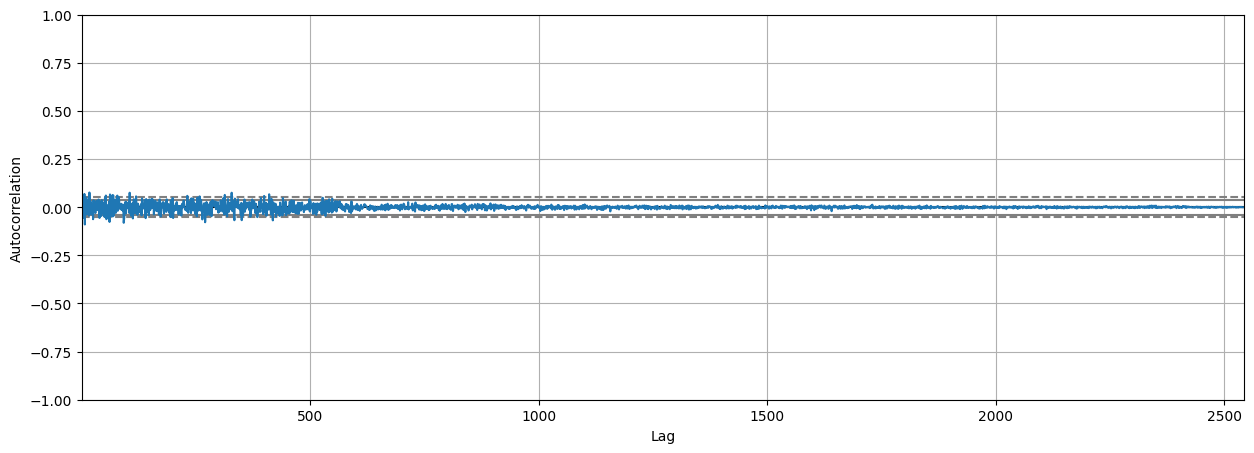

In [132]:
from matplotlib.pylab import rcParams

diff_train_data_close = train_data['Close_AAPL'].diff()
diff_train_data_close = diff_train_data_close.dropna()
rcParams['figure.figsize'] = 15, 5
pd.plotting.autocorrelation_plot(diff_train_data_close);

Our price series behaves like a random walk, which means:

an efficient market hypothesis (EMH): all known information is priced in.

most stationarity tests (like ADF) will likely reject stationarity of the raw price, but accept stationarity for the differenced series.

THIS IS DOUBLE-EDGED: DESIRABLE SINCE THERE ARE NO LEAKAGE, BUT AVOIDANT SINCE RANDOM PRICES DO NOT HELP US TO PREDICT TOMORROW

<h2>Checking residuals on the data</h2>

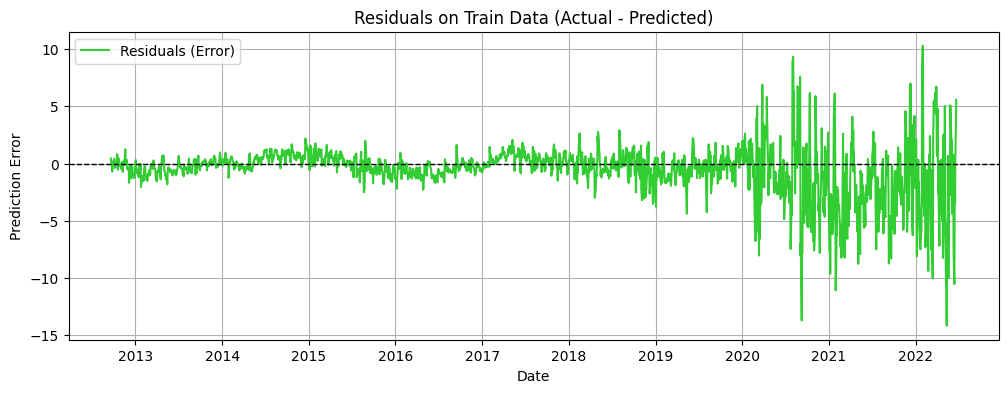

In [201]:
y_train_predicted = y_train_predicted_prices_lstm_gru
residuals = y_train_actual - y_train_predicted
train_data = train_data.sort_values(by="Date")
aligned_dates_train_data = train_data['Date'].iloc[-len(y_train_predicted_prices_lstm_gru):]

plt.figure(figsize=(12, 4))
plt.plot(aligned_dates_train_data, residuals, label="Residuals (Error)", color='limegreen')
plt.axhline(0, linestyle='--', color='black', linewidth=1)
plt.title("Residuals on Train Data (Actual - Predicted)")
plt.xlabel("Date")
plt.ylabel("Prediction Error")
plt.grid(True)
plt.legend()
plt.show()

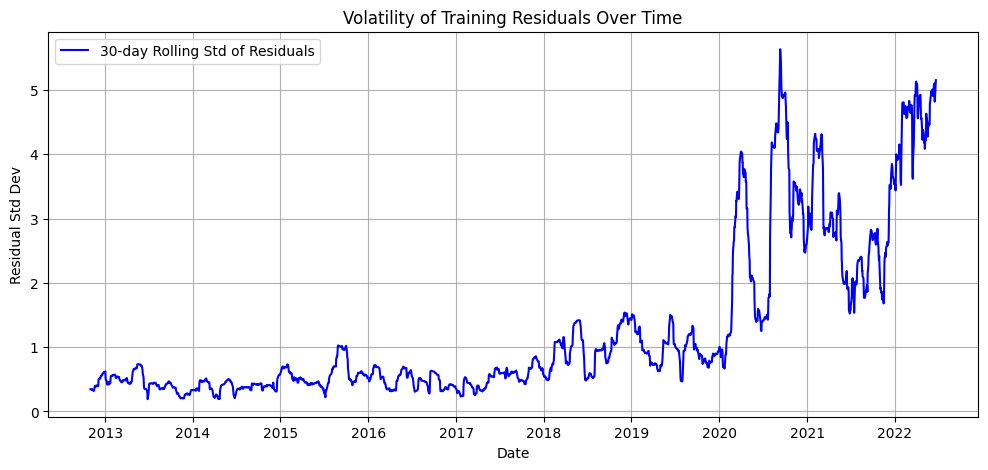

In [202]:
residuals_train = y_train_actual.flatten() - y_train_predicted_prices_lstm_gru.flatten()
rolling_std_train = pd.Series(residuals_train).rolling(window=30).std()
aligned_dates_train_data = train_data['Date'].iloc[-len(residuals_train):]

# plot
plt.figure(figsize=(12, 5))
plt.plot(aligned_dates_train_data, rolling_std_train, color='blue', label='30-day Rolling Std of Residuals')
plt.title("Volatility of Training Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residual Std Dev")
plt.grid(True)
plt.legend()
plt.show()


Not surprising at all, prices became volatile around the Covid time

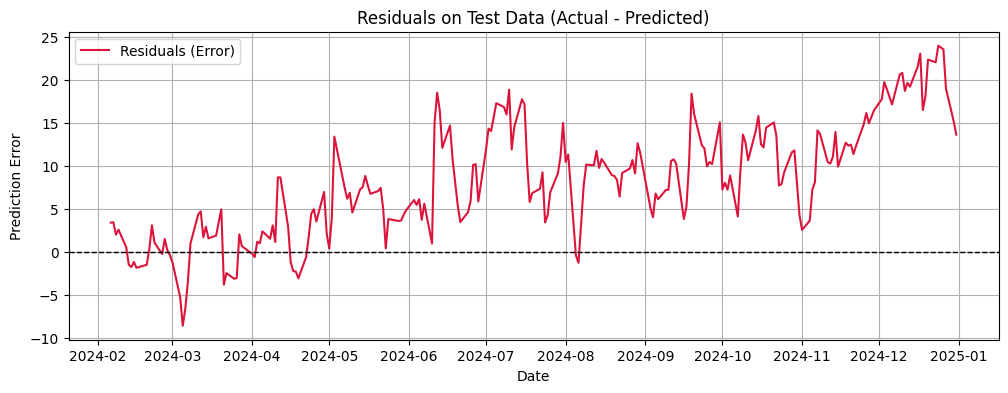

In [56]:
y_test_predicted = y_test_predicted_prices_lstm_gru
residuals = y_test_actual - y_test_predicted
test_data = test_data.sort_values(by="Date")
aligned_dates_test_data = test_data['Date'].iloc[-len(y_test_predicted_prices_lstm_gru):]

plt.figure(figsize=(12, 4))
plt.plot(aligned_dates_test_data, residuals, label="Residuals (Error)", color='crimson')
plt.axhline(0, linestyle='--', color='black', linewidth=1)
plt.title("Residuals on Test Data (Actual - Predicted)")
plt.xlabel("Date")
plt.ylabel("Prediction Error")
plt.grid(True)
plt.legend()
plt.show()

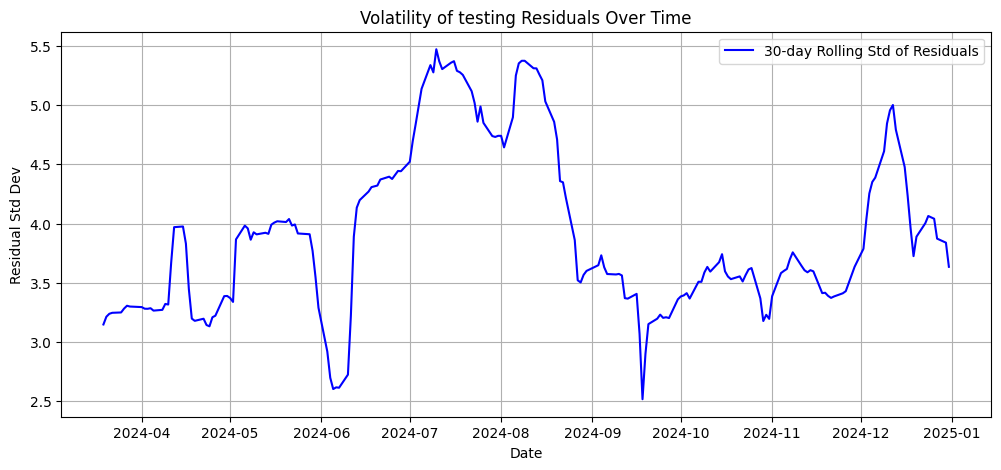

In [203]:
residuals_test = y_test_actual.flatten() - y_test_predicted_prices_lstm_gru.flatten()
rolling_std_test = pd.Series(residuals_test).rolling(window=30).std()
aligned_dates_test_data = test_data['Date'].iloc[-len(residuals_test):]

# plot
plt.figure(figsize=(12, 5))
plt.plot(aligned_dates_test_data, rolling_std_test, color='blue', label='30-day Rolling Std of Residuals')
plt.title("Volatility of testing Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residual Std Dev")
plt.grid(True)
plt.legend()
plt.show()


The classic drift problem

<h2>Insights about how the drift should be further addressed</h2>

In [152]:
model_lstm_gru = load_model('best_model_lstm_gru_after_optuna.h5')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


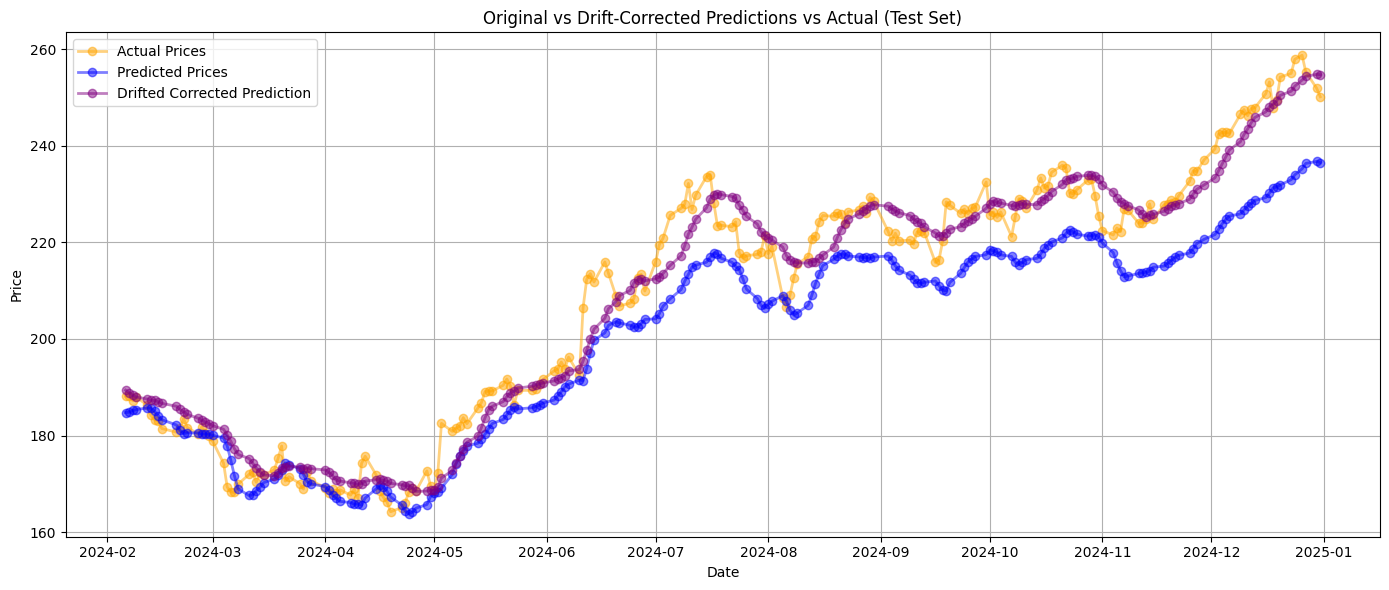

In [165]:
residual_preds = model_lstm_gru.predict(X_test).flatten()
rolling_mean_30_test_values = test_data['Close_AAPL'].rolling(window=10).mean().iloc[-len(residual_preds):].values
final_preds = residual_preds + rolling_mean_30_test_values 

aligned_dates = test_data['Date'].iloc[-len(final_preds):]
plt.figure(figsize=(14, 6))
plt.plot(aligned_dates, y_test_actual[-len(final_preds):], color="orange", marker='o', alpha=0.5, linewidth=2, label="Actual Prices")
plt.plot(aligned_dates, y_test_predicted_prices_lstm_gru[-len(final_preds):], color="blue", marker='o', alpha=0.5, linewidth=2, label="Predicted Prices")
plt.plot(aligned_dates, final_preds, color="purple", marker='o', alpha=0.5, linewidth=2, label="Drifted Corrected Prediction")
plt.title("Original vs Drift-Corrected Predictions vs Actual (Test Set)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

As further improvements, the neural needs to be better taught on how to adapt to new trends and fluctuations.

Unfortunately, relying solely on a 90-day lookback window may not be sufficient to detect newly emerging upward trends, especially under market drift.

To address this, incorporating an additional rolling window of 10 days could help the model relearn and adapt to recent changes, enabling better alignment with evolving price behavior.

Or we could just retry the process with a 45 days window instead